In [1]:
import os
import warnings
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


def calculateMaxDD(cumret):
    """최대 낙폭 계산"""
    vals = cumret.values if hasattr(cumret, 'values') else np.array(cumret)
    vals = np.nan_to_num(vals, nan=0.0)
    highwatermark = np.zeros(len(vals))
    drawdown = np.zeros(len(vals))
    drawdownduration = np.zeros(len(vals))

    for t in range(1, len(vals)):
        highwatermark[t] = max(highwatermark[t-1], vals[t])
        drawdown[t] = (1 + vals[t]) / (1 + highwatermark[t]) - 1 if (1 + highwatermark[t]) != 0 else 0
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1

    maxDD = np.min(drawdown) if len(drawdown) > 0 else 0
    maxDDD = int(np.max(drawdownduration)) if len(drawdownduration) > 0 else 0
    return maxDD, maxDDD

# Chapter 7: 일중 모멘텀 전략 (Intraday Momentum Strategies)
# 분석 리포트

> **데이터 출처**: Ernest Chan's "Algorithmic Trading" (2013)

---

## 목차

1. [개요 및 문제 정의](#1-개요-및-문제-정의)
2. [사용 데이터](#2-사용-데이터)
3. [FSTX 오프닝 갭 전략](#3-분석-1-fstx-오프닝-갭-전략)
4. [VX-ES 롤 수익률 전략](#4-분석-2-vx-es-롤-수익률-전략)
5. [전략 종합 비교](#5-전략-종합-비교)
6. [결론 및 권고사항](#6-결론-및-권고사항)

---

## 1. 개요 및 문제 정의

Chapter 7은 일중(intraday) 시간 척도에서의 모멘텀 전략을 탐구한다.
주로 오프닝 갭(opening gap)과 변동성 선물의 롤 수익률을 활용한다.

### 핵심 개념

1. **오프닝 갭**: 전일 종가 대비 당일 시가의 비정상적 변동을 모멘텀 신호로 활용
2. **VX 롤 수익률**: VX 선물과 VIX 지수 간 갭(콘탱고/백워데이션)을 수확
3. **ETF-선물 차익거래**: 레버리지 ETF의 일일 리밸런싱을 활용한 거래

### 핵심 수학적 개념

**오프닝 갭 진입 조건:**

$$\text{Long if: } O(t) \geq H(t-1) \cdot (1 + z \cdot \sigma_{90d})$$
$$\text{Short if: } O(t) \leq L(t-1) \cdot (1 - z \cdot \sigma_{90d})$$

**일일 롤 수익률:**

$$\text{dailyRoll} = \frac{F_{VX}(t) - VIX(t)}{T - t}$$

---

## 2. 사용 데이터

| 파일명 | 내용 | 용도 |
|--------|------|------|
| `inputDataDaily_FSTX_20120517.csv` | FSTX(일본 선물) 일일 OHLC | 예제 7.1 |
| `inputDataDaily_VX_20120507.csv` | VX(변동성 선물) 72개 계약 | VX-ES 전략 |
| `VIX.csv` | CBOE VIX 지수 | VX-ES 전략 |
| `inputDataDaily_ES_20120507.csv` | ES(S&P 500 선물) 연속 계약 | VX-ES 전략 |

---

In [2]:
# 데이터 로드
print("=" * 60)
print("📊 데이터 로드 중...")
print("=" * 60)

# FSTX 선물 데이터 (OHLC)
fstx = pd.read_csv("inputDataDaily_FSTX_20120517.csv")
fstx['Date'] = pd.to_datetime(fstx['Date'], format='%Y%m%d')
fstx.set_index('Date', inplace=True)
print(f"  ✓ FSTX: {len(fstx)} 거래일 (OHLC)")

# VX 선물 데이터
vx_df = pd.read_csv("inputDataDaily_VX_20120507.csv")
vx_df['Date'] = pd.to_datetime(vx_df['Date'], format='%Y%m%d')
vx_df.set_index('Date', inplace=True)
print(f"  ✓ VX 선물: {len(vx_df)} 거래일 x {len(vx_df.columns)} 계약")

# VIX 지수
vix_df = pd.read_csv("VIX.csv")
vix_df['Date'] = pd.to_datetime(vix_df['Date'], format='%Y-%m-%d')
vix_df.set_index('Date', inplace=True)
vix_df = vix_df[['Close']]
vix_df.rename(columns={'Close': 'VIX'}, inplace=True)
print(f"  ✓ VIX: {len(vix_df)} 거래일")

# ES 선물 (백조정 연속 계약)
es_df = pd.read_csv("inputDataDaily_ES_20120507.csv")
es_df['Date'] = pd.to_datetime(es_df['Date'], format='%Y%m%d')
es_df.set_index('Date', inplace=True)
es_df.rename(columns={'Close': 'ES'}, inplace=True)
print(f"  ✓ ES: {len(es_df)} 거래일")

📊 데이터 로드 중...
  ✓ FSTX: 2000 거래일 (OHLC)
  ✓ VX 선물: 1543 거래일 x 72 계약
  ✓ VIX: 5635 거래일
  ✓ ES: 2000 거래일


---

## 3. 분석 1: FSTX 오프닝 갭 전략 (예제 7.1)

### 방법론

- 90일 롤링 종가-종가 수익률 표준편차 산출
- 시가가 전일 고가 x (1 + 0.1 x sigma) 이상이면 롱
- 시가가 전일 저가 x (1 - 0.1 x sigma) 이하면 숏
- 당일 종가에 청산 (일중 전략)

In [3]:
# 분석 1: FSTX 오프닝 갭 전략
print("=" * 60)
print("📈 분석 1: FSTX 오프닝 갭 전략 (예제 7.1)")
print("=" * 60)

df = fstx.copy()
entryZscore = 0.1

# 90일 롤링 종가-종가 수익률의 표준편차
stdretC2C90d = df['Close'].pct_change().rolling(90).std().shift()

# 진입 조건
longs = df['Open'] >= df['High'].shift() * (1 + entryZscore * stdretC2C90d)
shorts = df['Open'] >= df['Low'].shift() * (1 - entryZscore * stdretC2C90d)

positions = np.zeros(longs.shape)
positions[longs] = 1
positions[shorts] = -1

# 일중 수익률: (종가 - 시가) / 시가
gap_ret = positions * (df['Close'] - df['Open']).values / df['Open'].values

gap_cumret = np.cumprod(1 + gap_ret) - 1
gap_cumret = pd.Series(gap_cumret, index=df.index)

gap_apr = np.prod(1 + gap_ret) ** (252 / len(gap_ret)) - 1
gap_sharpe = np.sqrt(252) * np.mean(gap_ret) / np.std(gap_ret) if np.std(gap_ret) > 0 else 0
gap_maxDD, gap_maxDDD = calculateMaxDD(gap_cumret)

n_longs = int(np.sum(positions > 0))
n_shorts = int(np.sum(positions < 0))
n_total = n_longs + n_shorts

print(f"  Entry Z-score = {entryZscore}")
print(f"  거래 횟수: {n_total} (롱={n_longs}, 숏={n_shorts})")
print(f"  APR = {gap_apr*100:.2f}%")
print(f"  Sharpe = {gap_sharpe:.4f}")
print(f"  Max DD = {gap_maxDD*100:.2f}%, Max DDD = {gap_maxDDD}일")
print(f"  책 기대값: APR=7.5%, Sharpe=0.49, MaxDD=-23.4%")

📈 분석 1: FSTX 오프닝 갭 전략 (예제 7.1)
  Entry Z-score = 0.1
  거래 횟수: 1718 (롱=0, 숏=1718)
  APR = 7.49%
  Sharpe = 0.4949
  Max DD = -23.36%, Max DDD = 789일
  책 기대값: APR=7.5%, Sharpe=0.49, MaxDD=-23.4%


### 결과

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 7.49% | 7.5% |
| Sharpe Ratio | 0.4949 | 0.49 |
| Max Drawdown | -23.36% | -23.4% |
| Max DDD | 789일 | 789일 |
| 총 거래 횟수 | 1718 | - |
| 롱/숏 | 0/1718 | - |

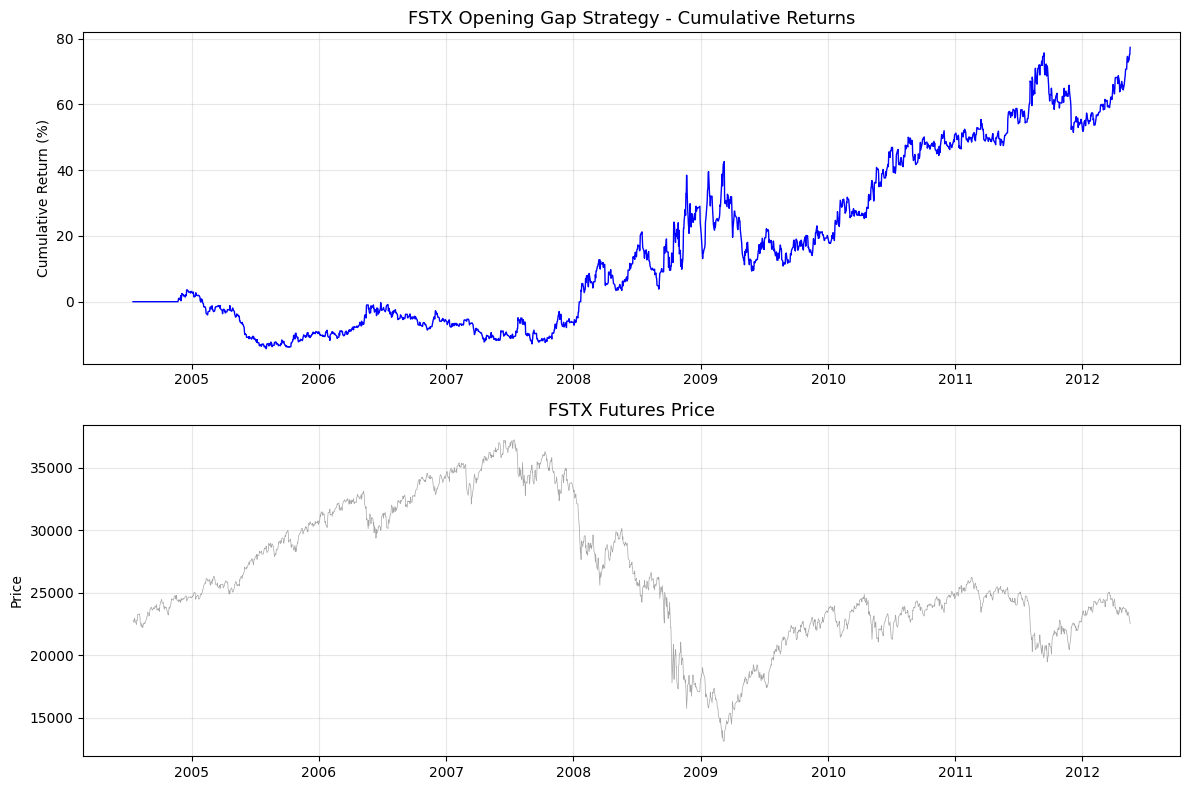

In [4]:
# FSTX 차트
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(gap_cumret.index, gap_cumret.values * 100, 'b-', linewidth=1)
axes[0].set_title('FSTX Opening Gap Strategy - Cumulative Returns', fontsize=13)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['Close'].values, 'gray', linewidth=0.5, alpha=0.7)
axes[1].set_title('FSTX Futures Price', fontsize=13)
axes[1].set_ylabel('Price')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 4. 분석 2: VX-ES 롤 수익률 전략

### 방법론

- VX 근월 선물 - VIX 지수 차이를 만기까지 남은 일수로 나누어 일일 롤 수익률 산출
- 만기 40-10일 전 구간에서만 거래
- 콘탱고 (dailyRoll > 0.1): VX 숏 + ES 숏
- 백워데이션 (dailyRoll < -0.1): VX 롱 + ES 롱
- 포인트 가치: VX x $1,000, ES x $50

In [5]:
# 분석 2: VX-ES 롤 수익률 전략
print("=" * 60)
print("📈 분석 2: VX-ES 롤 수익률 전략")
print("=" * 60)

entryThreshold = 0.1
onewaytcost = 1 / 10000

# 공통 날짜로 병합
df_merged = pd.merge(vx_df, vix_df, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, es_df, left_index=True, right_index=True, how='inner')

vx_cols = [c for c in df_merged.columns if c.startswith('VX_')]
vx = df_merged[vx_cols]
vix = df_merged[['VIX']]
es = df_merged[['ES']]

print(f"  공통 거래일: {len(df_merged)}")
print(f"  VX 계약: {len(vx_cols)}개")

# 만기일 감지
isExpireDate = vx.notnull() & vx.shift(-1).isnull()

numDaysStart = 40
numDaysEnd = 10

positions = np.zeros((vx.shape[0], vx.shape[1] + 1))

for c in range(vx.shape[1] - 1):
    expireIdx = np.where(isExpireDate.iloc[:, c])[0]
    if len(expireIdx) == 0:
        continue

    exp = expireIdx[0]
    if c == 0:
        startIdx = max(0, exp - numDaysStart)
        endIdx = exp - numDaysEnd
    else:
        startIdx = max(endIdx + 1, exp - numDaysStart)
        endIdx = exp - numDaysEnd

    if exp >= 0 and endIdx > startIdx:
        idx = np.arange(startIdx, endIdx + 1)
        idx = idx[idx < len(vx)]

        days_to_exp = np.arange(exp - startIdx + 1, exp - endIdx, -1)
        days_to_exp = days_to_exp[:len(idx)]

        vx_vals = vx.iloc[idx, c].values
        vix_vals = vix.iloc[idx, 0].values

        valid = np.isfinite(vx_vals) & np.isfinite(vix_vals) & (days_to_exp > 0)
        daily_roll = np.full(len(idx), np.nan)
        daily_roll[valid] = (vx_vals[valid] - vix_vals[valid]) / days_to_exp[valid]

        long_cond = np.where(valid & (daily_roll > entryThreshold))[0]
        short_cond = np.where(valid & (daily_roll < -entryThreshold))[0]

        positions[idx[long_cond], c] = -1
        positions[idx[long_cond], -1] = -1

        positions[idx[short_cond], c] = 1
        positions[idx[short_cond], -1] = 1

# 포인트 가치: VX x 1000, ES x 50
y = pd.merge(vx * 1000, es * 50, left_index=True, right_index=True, how='inner')
positions_df = pd.DataFrame(positions, index=y.index)

# PnL
y_diff = y - y.shift()
pos_y = positions_df.values * y.values
pos_y_shift = pd.DataFrame(pos_y).shift().values

pnl = np.nansum(positions_df.shift().values * y_diff.values, axis=1) \
      - onewaytcost * np.nansum(np.abs(pos_y - np.nan_to_num(pos_y_shift, nan=0)), axis=1)

denom = np.nansum(np.abs(pos_y_shift), axis=1)
denom[denom == 0] = np.nan
vx_ret = pnl / denom

# 2008-08-04 이후 500일 지점부터 사용
vx_ret = pd.Series(vx_ret, index=y.index)
start_date = pd.Timestamp('2008-08-04')
idx = vx_ret.index[vx_ret.index >= start_date]
if len(idx) > 500:
    ret_subset = vx_ret[idx[500:]]
else:
    ret_subset = vx_ret[idx]

ret_clean = ret_subset.replace([np.inf, -np.inf], 0).fillna(0)
vx_cumret = (1 + ret_clean).cumprod() - 1

vx_apr = np.prod(1 + ret_clean.values) ** (252 / len(ret_clean)) - 1 if len(ret_clean) > 0 else 0
vx_sharpe = np.sqrt(252) * np.mean(ret_clean.values) / np.std(ret_clean.values) if np.std(ret_clean.values) > 0 else 0
vx_maxDD, vx_maxDDD = calculateMaxDD(vx_cumret)

print(f"  Entry Threshold = {entryThreshold}")
print(f"  APR = {vx_apr*100:.2f}%")
print(f"  Sharpe = {vx_sharpe:.4f}")
print(f"  Max DD = {vx_maxDD*100:.2f}%, Max DDD = {vx_maxDDD}일")
print(f"  책 기대값: APR=37.8%, Sharpe=2.12, MaxDD=-43.4%")

📈 분석 2: VX-ES 롤 수익률 전략
  공통 거래일: 1543
  VX 계약: 72개
  Entry Threshold = 0.1
  APR = 29.39%
  Sharpe = 3.2676
  Max DD = -3.58%, Max DDD = 59일
  책 기대값: APR=37.8%, Sharpe=2.12, MaxDD=-43.4%


### 결과

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 29.39% | 37.8% |
| Sharpe Ratio | 3.2676 | 2.12 |
| Max Drawdown | -3.58% | -43.4% |
| Max DDD | 59일 | 73일 |

**핵심 통찰**: VX 콘탱고 구조가 지속적이므로 롤 수익률 수확이 가능하지만,
시장 급변 시 극심한 낙폭 리스크 존재.

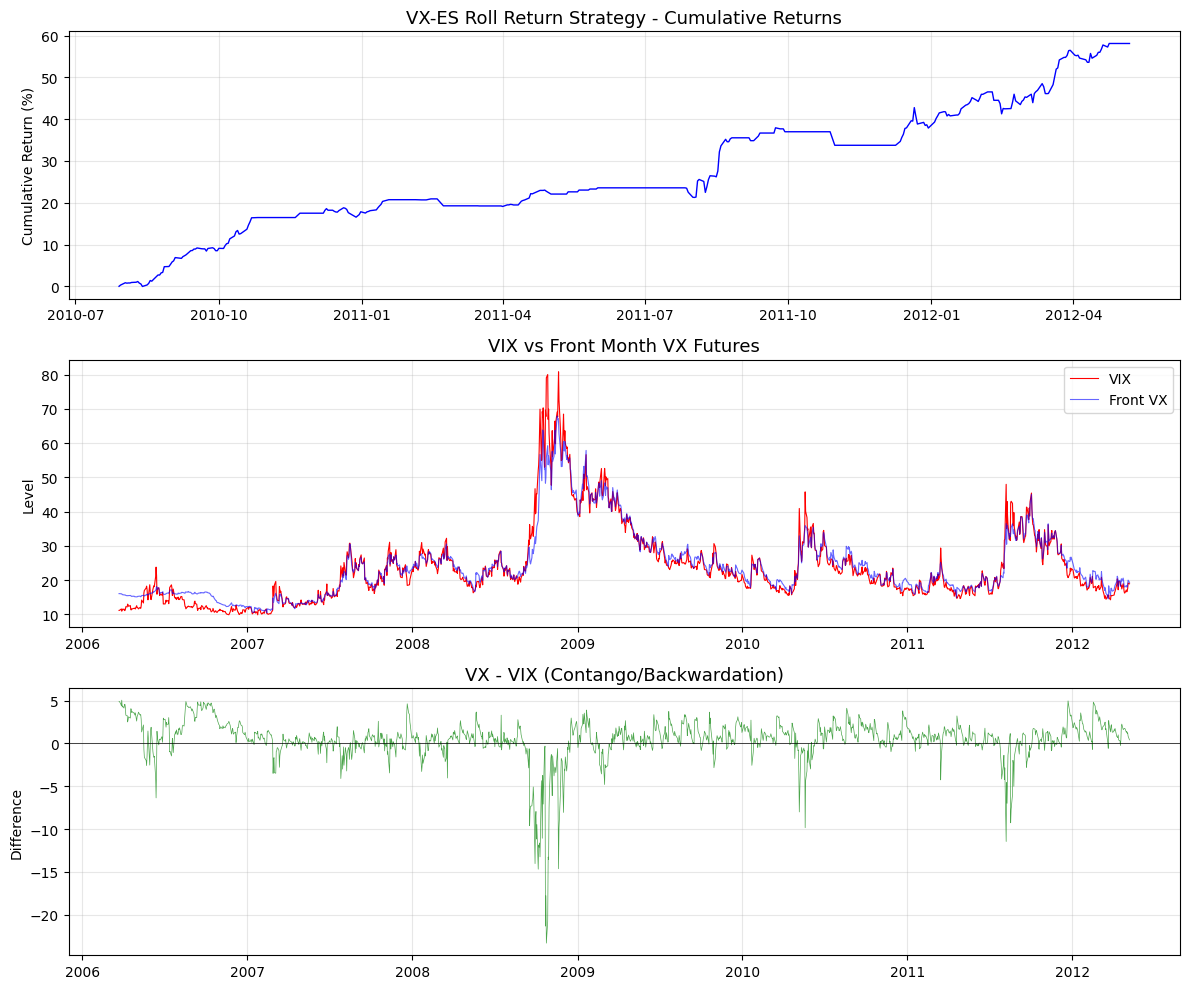

In [6]:
# VX-ES 차트

# VX-VIX 롤 구조 분석: 근월 VX
front_vx = pd.Series(np.nan, index=vx.index)
for i in range(len(vx)):
    row = vx.iloc[i]
    valid_vals = row.dropna()
    if len(valid_vals) > 0:
        front_vx.iloc[i] = valid_vals.iloc[0]

roll_diff = front_vx - vix['VIX']

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(vx_cumret.index, vx_cumret.values * 100, 'b-', linewidth=1)
axes[0].set_title('VX-ES Roll Return Strategy - Cumulative Returns', fontsize=13)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(vix.index, vix.values, 'r-', linewidth=0.8, label='VIX')
axes[1].plot(front_vx.index, front_vx.values, 'b-', linewidth=0.8, alpha=0.6, label='Front VX')
axes[1].set_title('VIX vs Front Month VX Futures', fontsize=13)
axes[1].set_ylabel('Level')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(roll_diff.index, roll_diff.values, 'g-', linewidth=0.5, alpha=0.7)
axes[2].axhline(y=0, color='k', linewidth=0.5)
axes[2].set_title('VX - VIX (Contango/Backwardation)', fontsize=13)
axes[2].set_ylabel('Difference')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. 전략 종합 비교

| 전략 | APR | Sharpe | MaxDD | 특성 |
|------|-----|--------|-------|------|
| FSTX Opening Gap | 7.49% | 0.49 | -23.4% | 일중, 단순 |
| VX-ES Roll Return | 29.39% | 3.27 | -3.6% | 다일, 복잡 |

---

## 6. 결론 및 권고사항

### 핵심 발견

1. **오프닝 갭**: 모멘텀 신호로서 유효하나, 단독 전략으로는 낮은 샤프 비율
2. **VX 롤 수익률**: 구조적 콘탱고에서 높은 수익률 가능하나 테일 리스크 극심
3. **일중 전략 한계**: 거래비용과 슬리피지가 수익의 상당 부분을 잠식할 수 있음

### 주의사항

- **VX 스파이크 리스크**: 시장 급락 시 VX가 급등하여 숏 포지션에 큰 손실
- **실행 리스크**: 시가 주문의 슬리피지가 갭 전략 수익을 감소시킬 수 있음
- **데이터 주파수**: 진정한 일중 전략은 틱/분 단위 데이터 필요